#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/t/ab8726f0cfc84544abbae69a6be88071

## Librerias

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error ,mean_squared_error
import urllib.request
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

## Data

In [2]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
train_raw = pd.read_csv("C:/Users/jamf1/OneDrive/Documents/BOOTCAMP/Laptop/KAGGLE MODELS/DATA/train.csv")


## Data exploration

In [3]:
def modify_data (train):
    
    train.set_index("id", inplace=True)
    train["Weight"] = train["Weight"].str.split("k", expand=True)[0].astype(float)
    train.rename(columns={"Weight":"Weight(kg)"}, inplace=True)

    train["Ram"] = train["Ram"].str.split("G", expand=True)[0].astype(float)
    train.rename(columns={"Ram":"Ram(GB)"}, inplace=True)

    memory = train["Memory"].str.split("+", expand=True)
    memory_2 = np.where(memory[1].isnull(), 0, (np.where(memory[1].str.contains("TB"), memory[1].str.split("TB", expand = True)[0], memory[1].str.split("GB", expand = True)[0])))
    memory_1 =np.where(memory[0].str.contains("TB"),  memory[0].str.split("TB", expand = True)[0], memory[0].str.split("GB", expand = True)[0])
    discos =np.where(memory[1].isnull(), 1, 2)
    train["Memory1 (GB)"] = memory_1
    train["Memory2 (GB)"] = memory_2
    train["Memory"] = train["Memory1 (GB)"].astype(float) + train["Memory2 (GB)"].astype(float)
    train.rename(columns={"Memory":"Memory Total (GB)"}, inplace=True)
    train["N_Discos"] = discos

    list_cpu_ghz = []
    for i in train[train["Cpu"].str.contains("GHz")]["Cpu"].str.split(" "):
        list_cpu_ghz.append(float((i[-1].split("G"))[0]))
    train["CPU (GHz)"] = list_cpu_ghz

    list_resolution = []
    for i in train[train["ScreenResolution"].str.contains("x")]["ScreenResolution"].str.split(" "):
        resolution = i[-1].split("x")
        list_resolution.append(float(resolution[0]) * float(resolution[-1]))
    train["ScreenResolution Total"] = list_resolution

    dict_OpSys = {'Netbook':1, 'Notebook':2, '2 in 1 Convertible':3, 'Ultrabook':4, 'Gaming':5,
       'Workstation':6}
    train["TypeName"] = train["TypeName"].replace(dict_OpSys)  

    dict_Company = {'Vero':1, 'Chuwi':2, 'Mediacom':3, 'Acer':4, 'Fujitsu':5, 'HP':6, 'Asus':7, 'Lenovo':8,
       'Xiaomi':9, 'Dell':10, 'Toshiba':11, 'Google':12, 'Samsung':13, 'Huawei':14, 'Microsoft':15,
       'Apple':16, 'MSI':17, 'LG':18, 'Razer':19}
    train["Company"] = train["Company"].replace(dict_Company)

    dict_OpSys_O = {'Chrome OS':1, 'No OS':2, 'Linux':3, 'Windows 10':4, 'Mac OS X':5, 'Windows 10 S':6,
       'Windows 7':7, 'macOS':8, "Android":9}
    train["OpSys"] = train["OpSys"].replace(dict_OpSys_O)

    train["Memory1 (GB)"] = train["Memory1 (GB)"].astype(float)
    train["Memory2 (GB)"] = train["Memory2 (GB)"].astype(float)
    
    return(train)


In [4]:
def add_mark(train, test=False):
    url = 'https://www.cpubenchmark.net/cpu_list.php#single-cpu'
    r = requests.get(url).text
    soup = BeautifulSoup(r, "html.parser")
    cpu = soup.find_all("tbody")[0]
    cpu = cpu.find_all("tr")
    
    list_new_cpu = []
    list_new_mark = []
    list_new_ghz = []
    for i in cpu:
        cpu_list = i.find_all("td")
        cpu_name = cpu_list[0].text
        cpu_mark = cpu_list[1].text
        
        if "," in cpu_mark:
            cpu_mark = cpu_mark.replace(",", "")

        if ("Intel Core M" in cpu_name or "Intel Core i5" in cpu_name or "Intel Core i7" in cpu_name) and "@" in cpu_name:
            if "-" in cpu_name:
                cpu_name_ghz = cpu_name.split(" ")[-1][:3]
                cpu_name = cpu_name.split(" ")[2].split("-")
                
                #print(cpu_name_ghz, cpu_name[0], cpu_mark)
                list_new_cpu.append(cpu_name[0])
                list_new_mark.append(float(cpu_mark))
                list_new_ghz.append(cpu_name_ghz)

    new_df = pd.DataFrame(list_new_cpu, columns=["i"])
    new_df["GHz"] = list_new_ghz
    new_df["mark"] = list_new_mark
    eee =new_df.groupby(["i", "GHz"]).mean()
    cpu_list_ref =[]
    for i in range(len(eee.index)):
        #print(i)
        CPU_reff = "Intel Core " + eee.index[i][0] + " " + eee.index[i][1] + "GHz"
        cpu_list_ref.append(CPU_reff)
    eee["CPU"] = cpu_list_ref
    eee.set_index("CPU", inplace=True)
    eee['mark'] = eee['mark'].apply(np.floor)


    list_cpu_raw = []
    list_cpu_clean = []
    list_mark = []

    for i in cpu:
        cpu_list = i.find_all("td")
        cpu_name = cpu_list[0].text
        cpu_mark = cpu_list[1].text
        
        if "," in cpu_mark:
            cpu_mark = cpu_mark.replace(",", "")
        
        if "Intel" in cpu_name and "m5-7Y54" not in cpu_name:       

            if "-" in cpu_name:
                if "v5" in cpu_name:
                    cpu_name_validation = (cpu_name.split(" ")[-4].split("-")[-1])
                else:
                    cpu_name_validation = (cpu_name.split(" ")[-3].split("-")[-1])
                #print(cpu_name_validation)
            else:
                cpu_name_validation = cpu_name.split(" @")[0].split(" ")[-1]
            list_cpu_raw.append(cpu_name)
            list_cpu_clean.append(cpu_name_validation)
            list_mark.append(float(cpu_mark))
            #print(cpu_name, cpu_name_validation)
            # list_mark

            #print(cpu_name, cpu_name_validation, cpu_mark)
        if "PRO" not in cpu_name and "AMD" in cpu_name and "LE" not in cpu_name and "Mobile" not in cpu_name:
            if "-" in cpu_name:
                if len(cpu_name.split(" "))< 3:
                    cpu_name_validation = cpu_name.split(" ")[-1].split("-")[-1]
                else:    
                    cpu_name_validation = cpu_name.split(" ")[-2].split("-")[-1]
            else:
                cpu_name_validation = cpu_name.split(" ")[-1]

            
            list_cpu_raw.append(cpu_name)
            list_cpu_clean.append(cpu_name_validation)
            list_mark.append(float(cpu_mark))
            #print(cpu_name, cpu_name_validation)
        #print(cpu_name, cpu_name_validation, cpu_mark)


    df =pd.DataFrame(list_cpu_raw, columns=["Cpu_raw"])
    df["CPU"] = list_cpu_clean
    df["mark"] = list_mark



    cpu_ref = []
    for i in train["Cpu"].values:
        if "-" in i:
            if "v5" in i or "v6" in i or "V6" in i:
                cod = i.split(" ")[-3].split("-")[-1]
            else:
                cod = i.split(" ")[-2].split("-")[-1]
        else:
            cod = i.split(" ")[-2]
        cpu_ref.append(cod)

    train["Cpu ref"] = cpu_ref


    ccc = df.set_index("CPU")

    list_mark_merge = []
    for i in range(len(train["Cpu ref"].values)):
        if train["Cpu ref"].values[i] in list_cpu_clean:
            list_mark_merge.append(ccc.loc[train["Cpu ref"].values[i],"mark"])
        else:
            list_mark_merge.append(np.nan)  

    bb = train
    bb["mark"] = list_mark_merge

    if test == True:
        for i in range(len(bb.Cpu.values)):
            if bb.Cpu.values[i] in eee.index:
                bb.iloc[i, 13] = eee.loc[bb.iloc[i, 6]]

    else:
        for i in range(len(bb.Cpu.values)):
            if bb.Cpu.values[i] in eee.index:
                bb.iloc[i, 14] = eee.loc[bb.iloc[i, 6]]

    return bb
    

In [5]:
def add_mark_gpu(train_raw):
    list_new_gpu = []
    for i in train_raw.Gpu.values:
        if "Intel" in i:        
            if 'Intel HD Graphics' == i:
                i = 'Intel HD Graphics 620'

            if "Intel Iris Pro Graphics" == i:
                i = "Intel Iris Pro Graphics 6200"
            gpu = i.strip().split(" ")
            gpu = gpu[-3] + " " + gpu[-1]
    
        elif "AMD" in i:
            if "Graphics" in i:
                if 'AMD R4 Graphics' == i:
                    i = 'AMD Radeon R4 Graphics'
                gpu = i.split(" ")
                gpu = gpu[-3:-1]

            else:
                gpu = i.strip().split(" ")
                gpu = gpu[-2:]
            gpu = " ".join(gpu)

        else:
            gpu = i.strip().split(" ")
            gpu = gpu[-2:]
            gpu = " ".join(gpu)
        list_new_gpu.append(gpu)
        #print(gpu)


    train_raw["GPU"] = list_new_gpu

    list_gpu = []
    list_mark = []

    url = 'https://www.videocardbenchmark.net/gpu_list.php'
    r = requests.get(url).text
    soup = BeautifulSoup(r, "html.parser")
    cpu = soup.find_all("tbody")[0]
    cpu = cpu.find_all("tr")
    for i in cpu:
        cpu_list = i.find_all("td")
        cpu_name = cpu_list[0].text
        cpu_mark = int(cpu_list[1].text)

        if "GeForce" in cpu_name: 
            
            cpu_name = " ".join(cpu_name.split(" ")[-2:])   
            
            list_mark.append(cpu_mark)
            list_gpu.append(cpu_name)
            #print(cpu_name)

        elif "Intel" in cpu_name and "Driver" not in cpu_name:
            cpu_name = " ".join(cpu_name.split(" ")[-2:])
            list_mark.append(cpu_mark)
            list_gpu.append(cpu_name)
            
        elif "Radeon" in  cpu_name and "RadeonT" not in cpu_name:
            
            cpu_name = " ".join(cpu_name.split(" ")[-2:])
            #print(cpu_name)
            list_mark.append(cpu_mark)
            list_gpu.append(cpu_name)
            #print(cpu_mark, cpu_name)

        elif "Quadro" in  cpu_name:
            
            list_mark.append(cpu_mark)
            list_gpu.append(cpu_name)
            #print(cpu_name)

        
    list_missing =["Radeon R5", "GTX 930MX", "HD 400", "GTX1050 Ti", "GTX 1050Ti", "HD 405", "GeForce 150MX", 'Quadro M2200M', 'Pro 6200',
                    'GT 940MX', 'Radeon R7', 'FirePro W4190M', 'GTX 940M', 'GeForce 960M', 'GTX 1050M', 'R5 M420X', 'GeForce 920', 'Quadro M620M',
                    'Quadro M520M', 'GTX 1070M', 'HD 540', 'Intel 620', 'GeForce GTX1060', 'GTX 960<U+039C>', 'AMD R17M-M1-70', 'GTX 940MX']
    list_mark_missing = [299, 1302, 218, 6314, 6314, 255, 3310, 4317, 1429, 1507, 690, 1085, 1102, 3432, 49, 470, 871, 2820, 1981, 13470, 1256, 920,
    10075, 6045, 765, 1507]

    for j in  range(len(list_missing)):
        list_gpu.append(list_missing[j])   
        list_mark.append(list_mark_missing[j])
    df = pd.DataFrame(list_gpu, columns=["GPU"])
    df["mark"] = list_mark

    ccc = df.set_index("GPU")

    import numpy as np
    list_mark_merge = []
    for i in range(len(train_raw["GPU"].values)):
        if train_raw["GPU"].values[i] in list_gpu:
            list_mark_merge.append(ccc.loc[train_raw["GPU"].values[i],"mark"])
        else:
            list_mark_merge.append(np.nan)  
    list_mark_merge

    bb = train_raw
    bb["mark Gpu"] = list_mark_merge

    return bb

In [6]:
train  = add_mark(train_raw)
train = add_mark_gpu(train)
train = modify_data(train)


In [7]:
train

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory Total (GB),Gpu,OpSys,...,Price_euros,Cpu ref,mark,GPU,mark Gpu,Memory1 (GB),Memory2 (GB),N_Discos,CPU (GHz),ScreenResolution Total
id,,,,,,,,,,,,,,,,,,,,,
852,10,Inspiron 5767,2,17.3,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8.0,1.0,AMD Radeon R7 M445,3,...,865.0,7500U,3651.0,R7 M445,912,1.0,0.0,1,2.7,2073600.0
414,7,ZenBook Flip,3,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256.0,Intel HD Graphics 620,4,...,928.0,7200U,3413.0,HD 620,943,256.0,0.0,1,2.5,2073600.0
283,8,Ideapad 320-15IKBN,2,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,6.0,256.0,Intel HD Graphics 620,4,...,579.0,7200U,3413.0,HD 620,943,256.0,0.0,1,2.5,2073600.0
669,4,Aspire 3,2,15.6,1366x768,Intel Core i3 6006U 2GHz,4.0,128.0,Intel HD Graphics 520,3,...,412.0,6006U,2277.0,HD 520,865,128.0,0.0,1,2.0,1049088.0
1287,6,15-AC110nv (i7-6500U/6GB/1TB/Radeon,2,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6.0,1.0,AMD Radeon R5 M330,4,...,764.0,6500U,3278.0,R5 M330,595,1.0,0.0,1,2.5,1049088.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,6,15-BW094nd (A6-9220/8GB/128GB/W10),2,15.6,1366x768,AMD A6-Series A6-9220 2.5GHz,8.0,128.0,AMD Radeon R4 Graphics,4,...,445.9,9220,1285.0,Radeon R4,331,128.0,0.0,1,2.5,1049088.0
794,16,"MacBook 12""",4,12.0,IPS Panel Retina Display 2304x1440,Intel Core M 1.2GHz,8.0,512.0,Intel HD Graphics 5300,5,...,1165.0,M,2057.0,HD 5300,389,512.0,0.0,1,1.2,3317760.0
1057,4,Aspire ES1-523,2,15.6,1366x768,AMD A8-Series 7410 2.2GHz,8.0,1.0,AMD Radeon R5,4,...,449.0,7410,1799.0,Radeon R5,299,1.0,0.0,1,2.2,1049088.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 852 to 373
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Company                 912 non-null    int64  
 1   Product                 912 non-null    object 
 2   TypeName                912 non-null    int64  
 3   Inches                  912 non-null    float64
 4   ScreenResolution        912 non-null    object 
 5   Cpu                     912 non-null    object 
 6   Ram(GB)                 912 non-null    float64
 7   Memory Total (GB)       912 non-null    float64
 8   Gpu                     912 non-null    object 
 9   OpSys                   912 non-null    int64  
 10  Weight(kg)              912 non-null    float64
 11  Price_euros             912 non-null    float64
 12  Cpu ref                 912 non-null    object 
 13  mark                    912 non-null    float64
 14  GPU                     912 non-null    

## Data processing

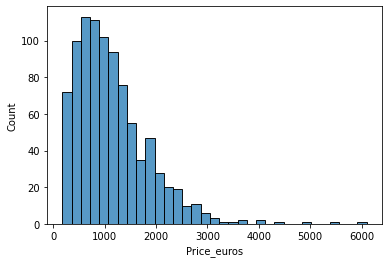

In [9]:
sns.histplot(data=train, x="Price_euros");


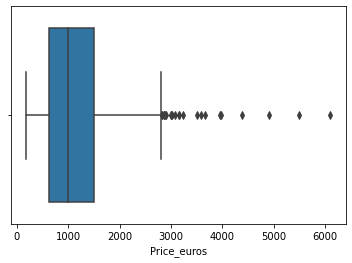

In [10]:
sns.boxplot(x = train["Price_euros"]);

In [11]:
p_25 = np.percentile(train["Price_euros"], 25)
p_50 = np.percentile(train["Price_euros"], 50)
p_75 = np.percentile(train["Price_euros"], 75)

print("Valor del cuartil 25:", p_25)
print("Valor del cuartil 50:", p_50)
print("Valor del cuartil 75:", p_75)

IQR = p_75 - p_25
maximun = p_75 + (1.5*IQR)
minimum = p_25 - (1.5*IQR)
print("Minimum:", minimum )
print("Maximum:", maximun )

Valor del cuartil 25: 615.5
Valor del cuartil 50: 989.0
Valor del cuartil 75: 1493.35
Minimum: -701.2749999999999
Maximum: 2810.125


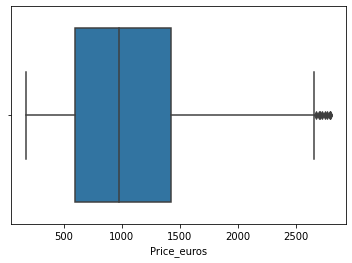

In [12]:
train.drop(train[train["Price_euros"]>maximun].index, axis = 0, inplace=True)
sns.boxplot(x = train["Price_euros"]);

In [13]:
p_25 = np.percentile(train["Price_euros"], 25)
p_50 = np.percentile(train["Price_euros"], 50)
p_75 = np.percentile(train["Price_euros"], 75)

print("Valor del cuartil 25:", p_25)
print("Valor del cuartil 50:", p_50)
print("Valor del cuartil 75:", p_75)

IQR = p_75 - p_25
maximun = p_75 + (1.5*IQR)
minimum = p_25 - (1.5*IQR)
print("Minimum:", minimum )
print("Maximum:", maximun )

Valor del cuartil 25: 600.425
Valor del cuartil 50: 973.0
Valor del cuartil 75: 1428.5
Minimum: -641.6875000000002
Maximum: 2670.6125


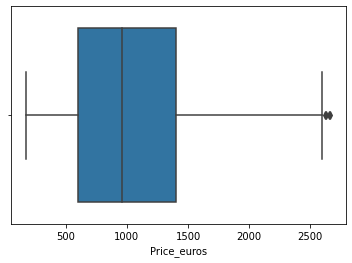

In [14]:
train.drop(train[train["Price_euros"]>maximun].index, axis = 0, inplace=True)
sns.boxplot(x = train["Price_euros"]);

In [15]:
p_25 = np.percentile(train["Price_euros"], 25)
p_50 = np.percentile(train["Price_euros"], 50)
p_75 = np.percentile(train["Price_euros"], 75)

print("Valor del cuartil 25:", p_25)
print("Valor del cuartil 50:", p_50)
print("Valor del cuartil 75:", p_75)

IQR = p_75 - p_25
maximun = p_75 + (1.5*IQR)
minimum = p_25 - (1.5*IQR)
print("Minimum:", minimum )
print("Maximum:", maximun )

Valor del cuartil 25: 599.0
Valor del cuartil 50: 959.0
Valor del cuartil 75: 1403.0
Minimum: -607.0
Maximum: 2609.0


<Figure size 1440x1440 with 0 Axes>

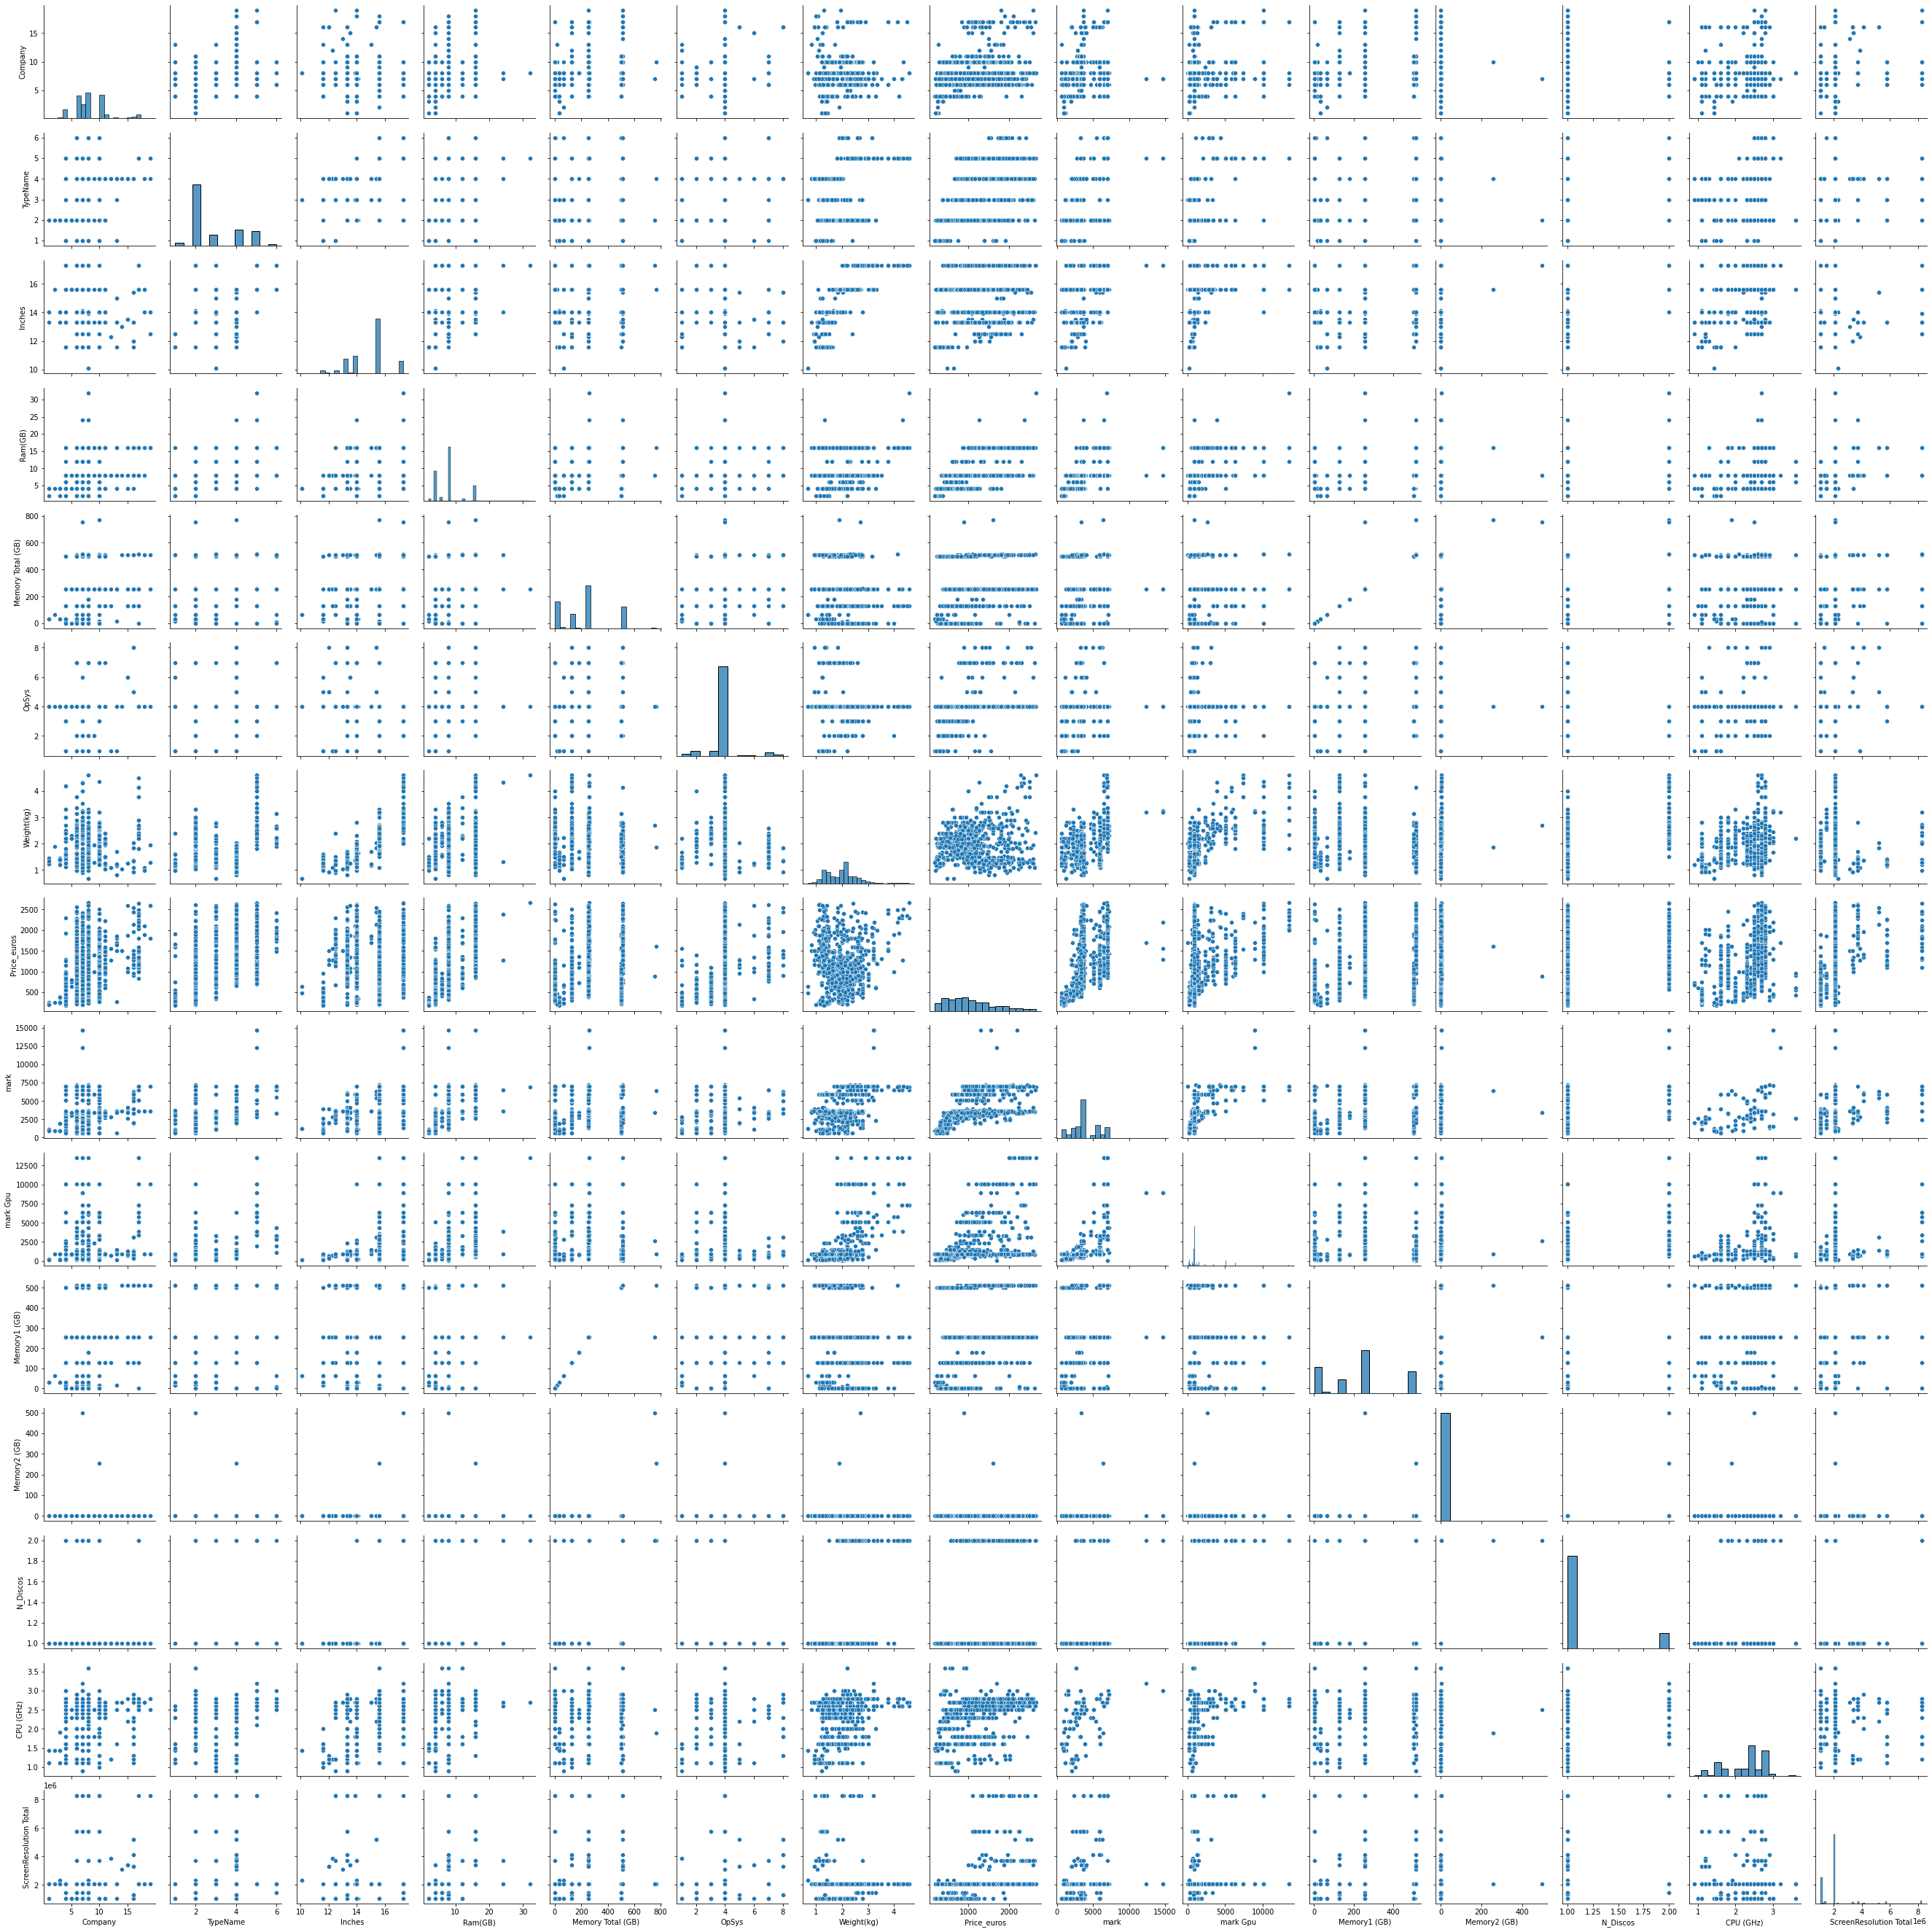

In [56]:
plt.figure(figsize=(20, 20))
sns.pairplot(train);

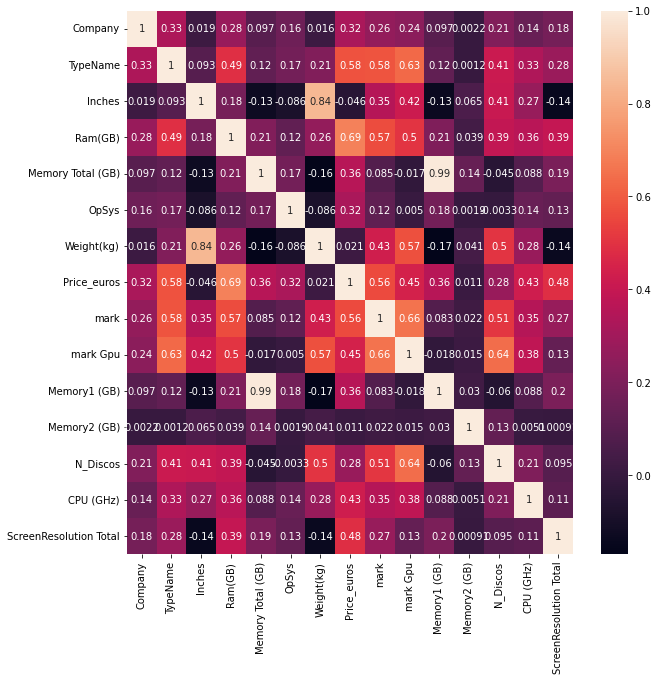

In [57]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True);

In [59]:
train.describe()

,Company,TypeName,Inches,Ram(GB),Memory Total (GB),OpSys,Weight(kg),Price_euros,mark,mark Gpu,Memory1 (GB),Memory2 (GB),N_Discos,CPU (GHz),ScreenResolution Total
count,881.000000,881.00000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,8.810000e+02
mean,8.166856,2.85017,14.950057,8.002270,226.382520,3.960272,1.990034,1061.059035,3891.704881,1895.130533,225.370034,1.012486,1.144154,2.280795,2.113230e+06
std,2.988324,1.22392,1.414247,4.000567,174.559114,0.948449,0.607351,574.897258,1931.258172,2487.622719,172.967303,18.913405,0.351446,0.508603,1.273736e+06
min,1.000000,1.00000,10.100000,2.000000,1.000000,1.000000,0.690000,174.000000,588.000000,49.000000,1.000000,0.000000,1.000000,0.900000,1.049088e+06
25%,6.000000,2.00000,14.000000,4.000000,64.000000,4.000000,1.480000,599.000000,2717.000000,865.000000,64.000000,0.000000,1.000000,1.800000,1.440000e+06
50%,8.000000,2.00000,15.600000,8.000000,256.000000,4.000000,2.020000,959.000000,3413.000000,943.000000,256.000000,0.000000,1.000000,2.500000,2.073600e+06
75%,10.000000,4.00000,15.600000,8.000000,257.000000,4.000000,2.300000,1403.000000,5943.000000,1302.000000,256.000000,0.000000,1.000000,2.700000,2.073600e+06
max,19.000000,6.00000,17.300000,32.000000,768.000000,8.000000,4.600000,2663.000000,14664.000000,13470.000000,512.000000,500.000000,2.000000,3.600000,8.294400e+06


-----------------------------------------------------------------------------------------------------------------

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 852 to 373
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Company                 881 non-null    int64  
 1   Product                 881 non-null    object 
 2   TypeName                881 non-null    int64  
 3   Inches                  881 non-null    float64
 4   ScreenResolution        881 non-null    object 
 5   Cpu                     881 non-null    object 
 6   Ram(GB)                 881 non-null    float64
 7   Memory Total (GB)       881 non-null    float64
 8   Gpu                     881 non-null    object 
 9   OpSys                   881 non-null    int64  
 10  Weight(kg)              881 non-null    float64
 11  Price_euros             881 non-null    float64
 12  Cpu ref                 881 non-null    object 
 13  mark                    881 non-null    float64
 14  GPU                     881 non-null    

In [16]:
X = train[["Company", 'TypeName', 'Inches', "Ram(GB)", "ScreenResolution Total", 'Memory Total (GB)', 'Weight(kg)', "CPU (GHz)", "mark", 'mark Gpu',
 'Memory1 (GB)','Memory2 (GB)', 'N_Discos', "OpSys"]]
y = train['Price_euros'].copy()
X.shape

(881, 14)

In [127]:
y.shape

(881,)

### 2. Dividir X_train, X_test, y_train, y_test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

In [29]:
print("Train X:", X_train.shape)
print("Test X:", X_test.shape)
print("Train y:", y_train.shape)
print("Test y:", y_test.shape)

Train X: (704, 14)
Test X: (177, 14)
Train y: (704,)
Test y: (177,)


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 3. Asignar el modelo (vacío) a una variable


In [131]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

In [132]:
predictions = modelo.predict(X_test)

In [133]:
print("TRAIN ERROR")
print("MAE: ", mean_absolute_error(y_train, modelo.predict(X_train)))
print("MAPE: ", mean_absolute_percentage_error(y_train, modelo.predict(X_train)))
print("MSE: ", mean_squared_error(y_train, modelo.predict(X_train)))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, modelo.predict(X_train))))

TRAIN ERROR
MAE:  230.23582140983683
MAPE:  0.25550590768256964
MSE:  92572.99414521262
RMSE:  304.25810448566955


In [134]:
print("TEST ERROR")
baseline_error = mean_squared_error(y_test, predictions)
print("MAE: ", mean_absolute_error(y_test, predictions))
print("MAPE: ", mean_absolute_percentage_error(y_test,predictions))
print("MSE: ", mean_squared_error(y_test,predictions))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,predictions)))

TEST ERROR
MAE:  245.79330996112293
MAPE:  0.26433974707047186
MSE:  98252.12079539684
RMSE:  313.4519433587816


In [497]:
modelo.coef_
coeff_df = pd.DataFrame(modelo.coef_,
                        ["Company", 'TypeName', 'Inches', "Ram(GB)", "ScreenResolution Total", 'Memory Total (GB)', 'Weight(kg)', "CPU (GHz)", "mark", 'mark Gpu',
 'Memory1 (GB)','Memory2 (GB)', 'N_Discos', "OpSys"],
                        columns=['Coefficient'])
coeff_df.sort_values('Coefficient', ascending=False)

,Coefficient
Ram(GB),208.809588
mark,107.770925
CPU (GHz),89.377215
ScreenResolution Total,87.470034
OpSys,79.476978
TypeName,73.131651
mark Gpu,59.273308
Memory1 (GB),42.295022
Memory Total (GB),41.356147
Company,10.459716


In [498]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)

print('MAE test', mean_absolute_error(y_test, ridge.predict(X_test)))
print('MSE test', mean_squared_error(y_test, ridge.predict(X_test)))
print('RMSE test', np.sqrt(mean_squared_error(y_test, ridge.predict(X_test))))

MAE test 248.9018569659458
MSE test 99304.11804484445
RMSE test 315.1255591741877


In [428]:
n_alphas = 100
alphas = np.logspace(-1, 5, n_alphas) 

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test)
    ridge_error = mean_squared_error(y_pred, y_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [429]:
min(err_ridge)

84471.02864222277

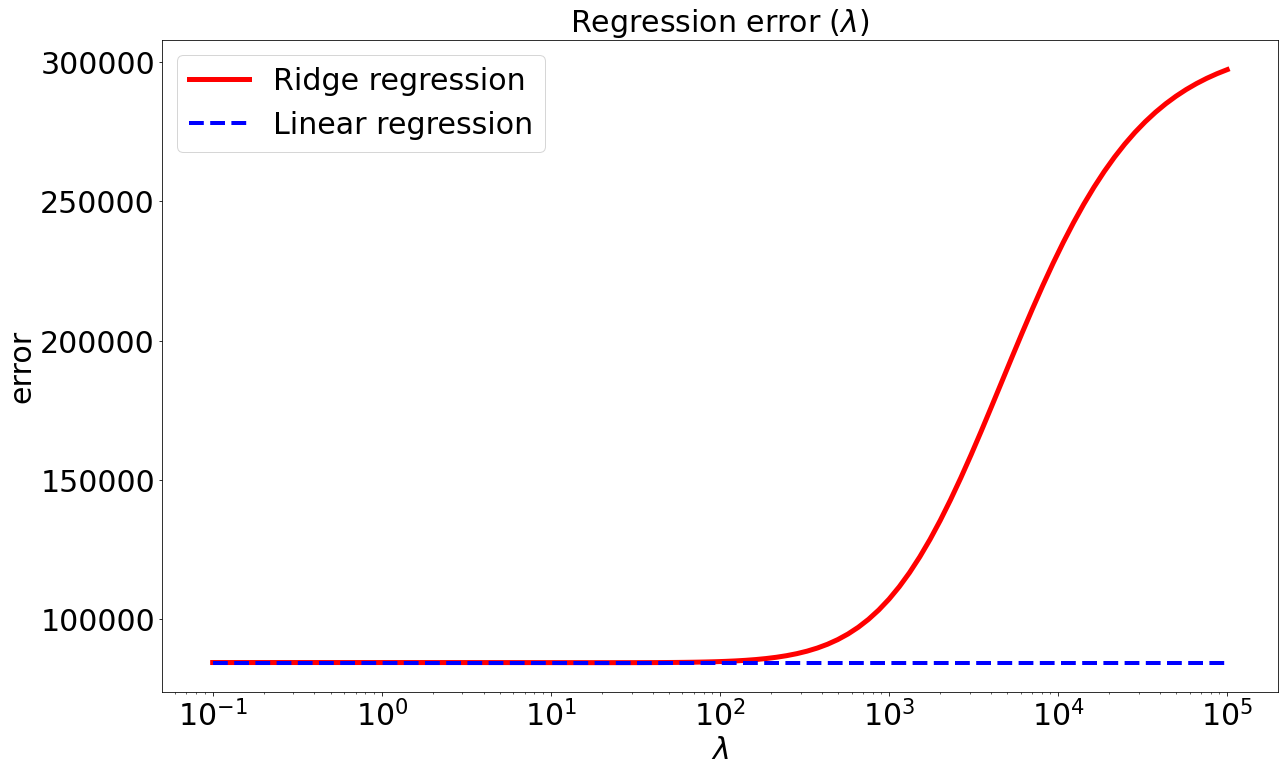

In [430]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [431]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=4.641588833612782)
lasso.fit(X_train, y_train)

print('MAE test', mean_absolute_error(y_test, lasso.predict(X_test)))
print('MSE test', mean_squared_error(y_test, lasso.predict(X_test)))
print('RMSE test', np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))))

MAE test 233.40348963898612
MSE test 83954.59210051187
RMSE test 289.7491882654926


In [432]:
n_alphas = 100
alphas = np.logspace(-10, 10, n_alphas) 

coef_lasso = []
err_lasso = []
baseline = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    
    coef_lasso.append(lasso.coef_)
    
    y_pred = lasso.predict(X_test)
    lasso_error = mean_squared_error(y_pred, y_test)
    
    err_lasso.append(lasso_error)
    baseline.append(baseline_error)

C:\Users\jamf1\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.771e+05, tolerance: 2.364e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\jamf1\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e+05, tolerance: 2.364e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\jamf1\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to i

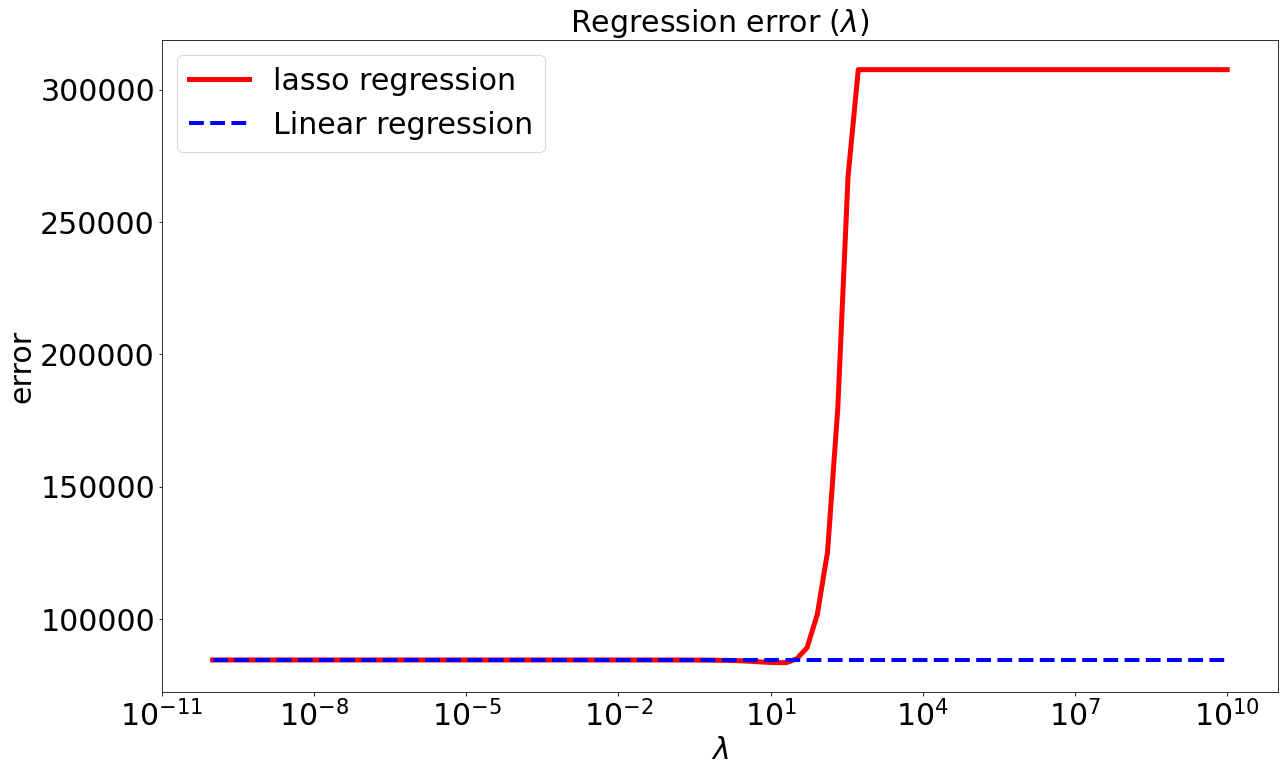

In [433]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="lasso regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [434]:
from sklearn.model_selection import GridSearchCV

elastic = Lasso()

parameters = {'alpha': np.logspace(-2,10,100),
              
            }

elastic_gs = GridSearchCV(elastic, parameters, cv=5, scoring='neg_mean_absolute_error')

elastic_gs.fit(X_train, y_train)

C:\Users\jamf1\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+05, tolerance: 1.854e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\jamf1\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.377e+05, tolerance: 1.911e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\jamf1\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to i

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-02, 1.32194115e-02, 1.74752840e-02, 2.31012970e-02,
       3.05385551e-02, 4.03701726e-02, 5.33669923e-02, 7.05480231e-02,
       9.32603347e-02, 1.23284674e-01, 1.62975083e-01, 2.15443469e-01,
       2.84803587e-01, 3.76493581e-01, 4.97702356e-01, 6.57933225e-01,
       8.69749003e-01, 1.14975700e+00, 1.51991108e+00, 2....
       1.62975083e+07, 2.15443469e+07, 2.84803587e+07, 3.76493581e+07,
       4.97702356e+07, 6.57933225e+07, 8.69749003e+07, 1.14975700e+08,
       1.51991108e+08, 2.00923300e+08, 2.65608778e+08, 3.51119173e+08,
       4.64158883e+08, 6.13590727e+08, 8.11130831e+08, 1.07226722e+09,
       1.41747416e+09, 1.87381742e+09, 2.47707636e+09, 3.27454916e+09,
       4.32876128e+09, 5.72236766e+09, 7.56463328e+09, 1.00000000e+10])},
             scoring='neg_mean_absolute_error')

In [435]:
elastic_gs.best_estimator_

Lasso(alpha=4.641588833612782)

In [436]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=10, l1_ratio=0.5)

elastic.fit(X_train, y_train)

print('MAE test', mean_absolute_error(y_test, elastic.predict(X_test)))
print('MSE test', mean_squared_error(y_test, elastic.predict(X_test)))
print('RMSE test', np.sqrt(mean_squared_error(y_test, elastic.predict(X_test))))

MAE test 330.85353981440306
MSE test 169748.0783174027
RMSE test 412.004949384595


In [437]:
from sklearn.model_selection import GridSearchCV

elastic = ElasticNet()

parameters = {'alpha': np.logspace(-1,15,100),
              'l1_ratio': np.arange(0,1,0.01)
            }

elastic_gs = GridSearchCV(elastic, parameters, cv=5, scoring='neg_mean_absolute_error')

elastic_gs.fit(X_train, y_train)

C:\Users\jamf1\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.552e+07, tolerance: 1.523e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\jamf1\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.480e+07, tolerance: 1.675e+04 Linear regression models with null weight for the l1 regularization ter

GridSearchCV(cv=3, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-01, 1.45082878e-01, 2.10490414e-01, 3.05385551e-01,
       4.43062146e-01, 6.42807312e-01, 9.32603347e-01, 1.35304777e+00,
       1.96304065e+00, 2.84803587e+00, 4.13201240e+00, 5.99484250e+00,
       8.69749003e+00, 1.26185688e+01, 1.83073828e+01, 2.65608778e+01,
       3.85352859e+01, 5.59081018e+01, 8.11130831e+...
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             scoring='neg_mean_absolute_error')

In [438]:
elastic_gs.best_estimator_

ElasticNet(alpha=0.9326033468832199, l1_ratio=0.99)

In [439]:
elastic_gs.best_params_

{'alpha': 0.9326033468832199, 'l1_ratio': 0.99}

In [440]:
elastic_gs.best_score_

-241.8663751414922

In [441]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.9326033468832199, l1_ratio=0.99)

elastic.fit(X_train, y_train)

print('MAE test', mean_absolute_error(y_test, elastic.predict(X_test)))
print('MSE test', mean_squared_error(y_test, elastic.predict(X_test)))
print('RMSE test', np.sqrt(mean_squared_error(y_test, elastic.predict(X_test))))

MAE test 233.98176344835122
MSE test 84393.26187426799
RMSE test 290.5051839025734


In [31]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree

dtr = DecisionTreeRegressor(min_samples_leaf=7, random_state=0)
dtr.fit(X_train,y_train)
y_pred = dtr.predict(X_test)

In [32]:
print("Coeficiente determinación", r2_score(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MAPE", mean_absolute_percentage_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

Coeficiente determinación 0.7862599599344571
MAE 185.823041406177
MAPE 0.18361205054337892
MSE 65525.29738094679
RMSE 255.97909559365738


In [33]:
print("Coeficiente determinación", r2_score(y_train, dtr.predict(X_train)))
print("MAE", mean_absolute_error(y_train, dtr.predict(X_train)))
print("MAPE", mean_absolute_percentage_error(y_train, dtr.predict(X_train)))
print("MSE", mean_squared_error(y_train, dtr.predict(X_train)))
print("RMSE", np.sqrt(mean_squared_error(y_train, dtr.predict(X_train))))

Coeficiente determinación 0.8588526360236652
MAE 151.56286557902322
MAPE 0.14743857765532173
MSE 47406.331183414666
RMSE 217.72995012954618


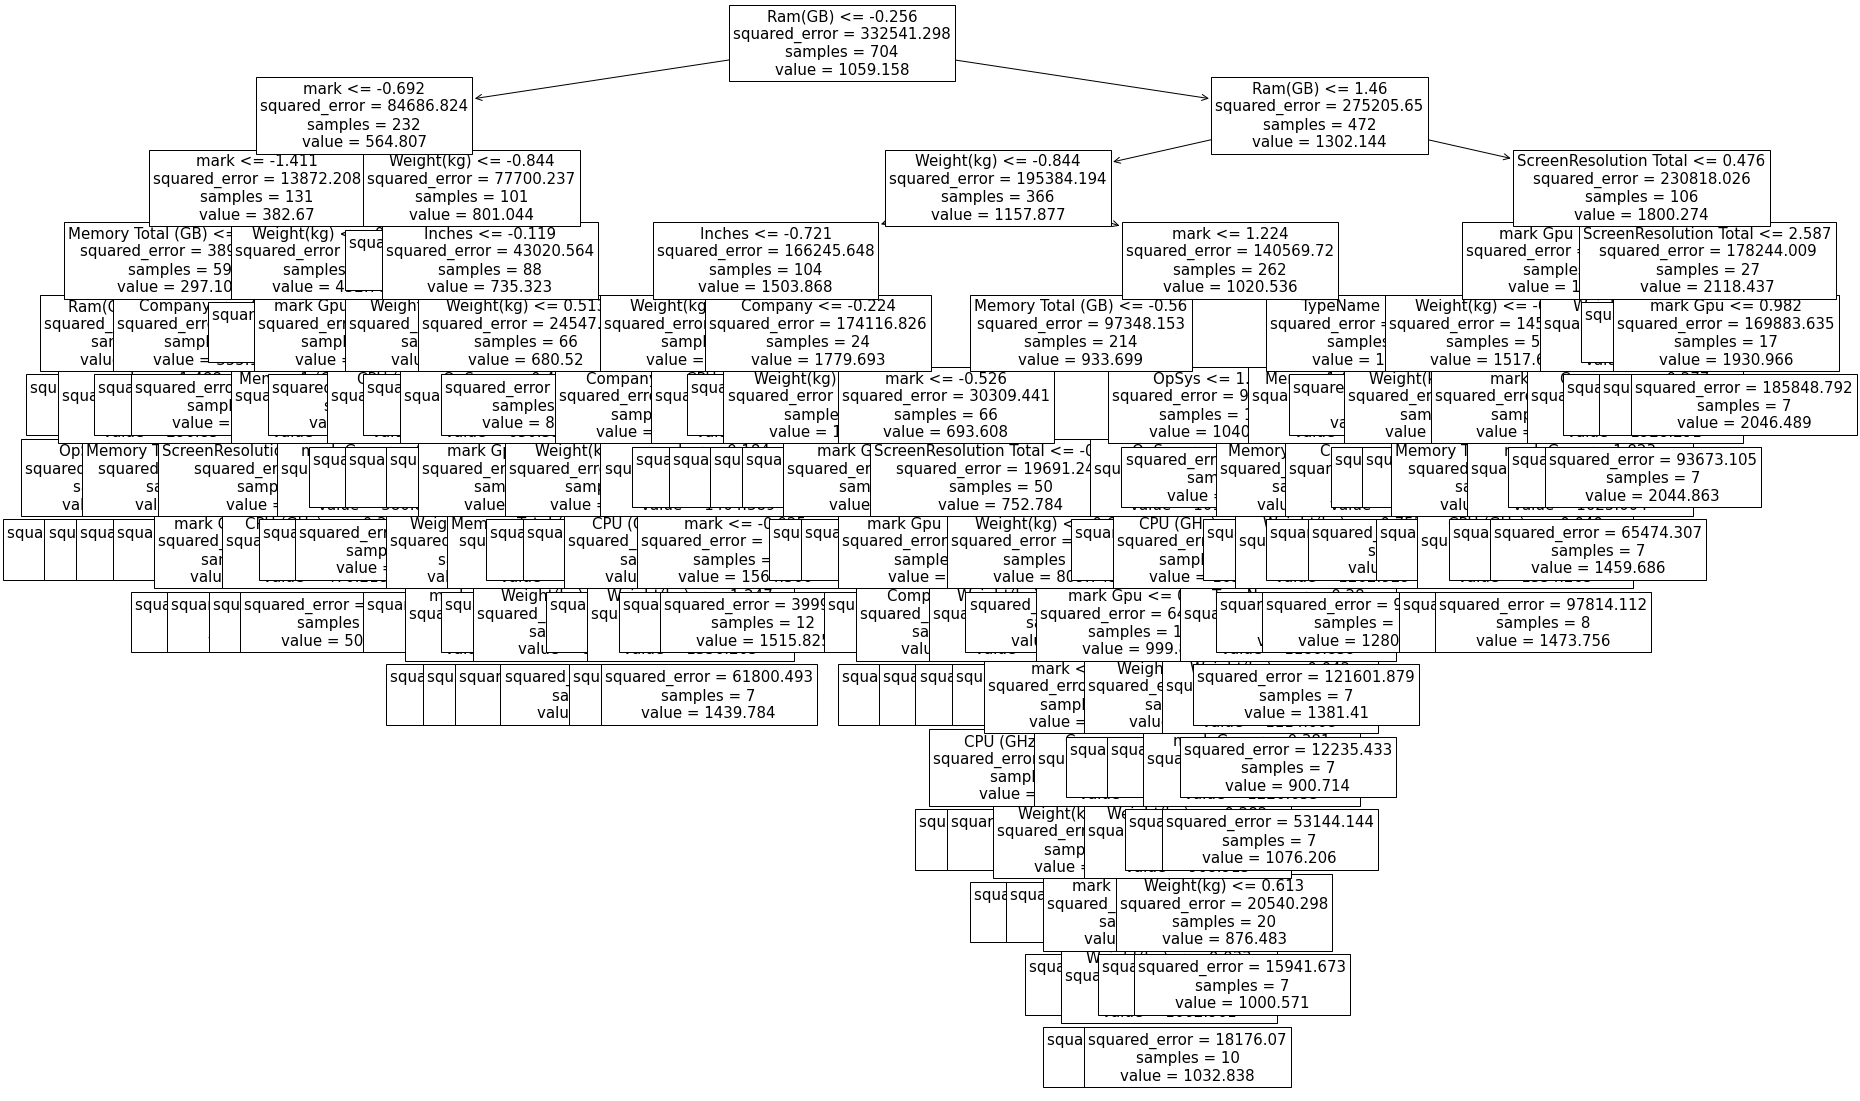

In [23]:
plt.figure(figsize=(30,20))

plot_tree(dtr, feature_names = X.columns, class_names = 'Price_euros', fontsize=15); #max_depth cambia la profundidad de la visualización

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 2. Carga los datos de `test.csv` para predecir.

In [34]:
X_pred_raw = pd.read_csv("C:/Users/jamf1/OneDrive/Documents/BOOTCAMP/Laptop/KAGGLE MODELS/DATA/test.csv")
X_pred1 = add_mark(X_pred_raw, True)
X_pred1 = add_mark_gpu(X_pred1)
X_pred1 = modify_data(X_pred1)
X_pred1

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory Total (GB),Gpu,OpSys,Weight(kg),Cpu ref,mark,GPU,mark Gpu,Memory1 (GB),Memory2 (GB),N_Discos,CPU (GHz),ScreenResolution Total
id,,,,,,,,,,,,,,,,,,,,
1184,6,Pavilion 15-BC000nv,2,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,6.0,1.0,Nvidia GeForce GTX 960M,4,2.18,6700HQ,6542.0,GTX 960M,3433.0,1.0,0.0,1,2.6,2073600.0
815,8,Thinkpad T470s,4,14.0,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8.0,256.0,Intel HD Graphics 620,4,1.32,7500U,3651.0,HD 620,943.0,256.0,0.0,1,2.7,2073600.0
1244,6,EliteBook 840,2,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4.0,256.0,Intel HD Graphics 520,7,1.54,6200U,3029.0,HD 520,865.0,256.0,0.0,1,2.3,2073600.0
1121,6,Spectre Pro,2,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8.0,256.0,Intel HD Graphics 520,4,1.16,6200U,3029.0,HD 520,865.0,256.0,0.0,1,2.3,2073600.0
443,8,IdeaPad 320-15IAP,2,15.6,Full HD 1920x1080,Intel Pentium Quad Core N4200 1.1GHz,4.0,128.0,Intel HD Graphics 505,4,2.20,N4200,2144.0,HD 505,340.0,128.0,0.0,1,1.1,2073600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,4,Aspire ES1-572,2,15.6,1366x768,Intel Core i3 6006U 2GHz,4.0,500.0,Intel HD Graphics 520,4,2.40,6006U,2277.0,HD 520,865.0,500.0,0.0,1,2.0,1049088.0
360,6,250 G6,2,15.6,1366x768,Intel Core i3 6006U 2GHz,4.0,500.0,Intel HD Graphics 520,4,1.86,6006U,2277.0,HD 520,865.0,500.0,0.0,1,2.0,1049088.0
965,10,Inspiron 3567,2,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4.0,1.0,AMD Radeon R5 M430,3,2.25,6006U,2277.0,R5 M430,648.0,1.0,0.0,1,2.0,1049088.0


In [75]:
X_pred1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 1184 to 1276
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Company                 391 non-null    int64  
 1   Product                 391 non-null    object 
 2   TypeName                391 non-null    int64  
 3   Inches                  391 non-null    float64
 4   ScreenResolution        391 non-null    object 
 5   Cpu                     391 non-null    object 
 6   Ram(GB)                 391 non-null    float64
 7   Memory Total (GB)       391 non-null    float64
 8   Gpu                     391 non-null    object 
 9   OpSys                   391 non-null    int64  
 10  Weight(kg)              391 non-null    float64
 11  Cpu ref                 391 non-null    object 
 12  mark                    389 non-null    float64
 13  GPU                     391 non-null    object 
 14  mark Gpu                385 non-null  

In [35]:
X_pred1.loc[1191, "mark"] = 861
X_pred1.loc[14, "mark"] = 2982
X_pred1.loc[387, "mark Gpu"] = 1347
X_pred1.loc[1191, "mark Gpu"] = 513
X_pred1.loc[517, "mark Gpu"] = 15240
X_pred1.loc[683, "mark Gpu"] = 827
X_pred1.loc[1103, "mark Gpu"] = 1515
X_pred1.loc[177, "mark Gpu"] = 11234


In [77]:
X_pred1.shape

(391, 20)

**¿Por qué da error?** 

In [36]:
X_pred = scaler.transform(X_pred1[["Company", 'TypeName', 'Inches', "Ram(GB)", "ScreenResolution Total", 'Memory Total (GB)', 'Weight(kg)', "CPU (GHz)", "mark", 'mark Gpu',
 'Memory1 (GB)','Memory2 (GB)', 'N_Discos', "OpSys"]])

In [37]:
predictions_submit = dtr.predict(X_pred)
predictions_submit

array([ 805.79      , 1788.2       , 1121.27090909, 1390.89      ,
        418.        , 1028.99888889,  805.79      ,  644.32230769,
       1091.37142857, 1111.16181818,  959.375     , 1262.73125   ,
        662.12428571, 1890.77166667,  861.28461538, 1240.11      ,
        658.12714286, 1111.16181818,  860.6775    ,  556.93857143,
        488.03625   , 1402.54285714, 1073.93142857,  556.93857143,
        756.93125   , 1175.9975    ,  334.31125   ,  407.865     ,
       1402.54285714, 2428.07142857,  418.        , 1402.54285714,
        873.71571429,  225.52083333,  750.375     , 2111.09142857,
       1150.71428571,  562.87363636,  435.88142857, 1403.30142857,
       1393.50142857, 1028.99888889, 1788.2       ,  435.88142857,
       1841.85714286,  861.28461538, 1111.16181818, 2428.07142857,
       1362.99875   ,  498.83833333, 1121.27090909, 1841.85714286,
        487.89727273,  498.83833333, 1876.2375    ,  727.55      ,
        805.79      , 1028.99888889, 1091.37142857, 2428.07142

IMPORTANTE: APLICAR LO MISMO A ESTOS DATOS QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [ ]:
# ¿Qué opináis?
# Sí

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

In [20]:
X_pred = pd.read_csv("Dataset/test.csv", index_col=0)
X_pred.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
id,,,,,,,,,,,
1184,HP,Pavilion 15-BC000nv,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,6GB,1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.18kg
815,Lenovo,Thinkpad T470s,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.32kg
1244,HP,EliteBook 840,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.54kg
1121,HP,Spectre Pro,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.16kg
443,Lenovo,IdeaPad 320-15IAP,Notebook,15.6,Full HD 1920x1080,Intel Pentium Quad Core N4200 1.1GHz,4GB,128GB SSD,Intel HD Graphics 505,Windows 10,2.2kg


### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [24]:
predictions_submit = modelo.predict(X_pred)
predictions_submit

array([ -260.20029487,   116.70396517,  9699.26794807, ...,
        8903.59284445, 10336.93013348,  -601.00685048])

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [38]:
sample = pd.read_csv("C:/Users/jamf1/OneDrive/Documents/BOOTCAMP/Laptop/KAGGLE MODELS/DATA/sample_submission.csv")

In [39]:
sample.head()

,id,Price_euros
0,1184,2158
1,815,511
2,1244,5290
3,1121,622
4,443,1140


In [399]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [360]:
submission = pd.DataFrame({"id": range(len(predictions_submit)), "Price_euros": predictions_submit})

In [40]:
submission = pd.DataFrame(X_pred1.index, columns=["id"])
submission["Price_euros"] = predictions_submit
submission

,id,Price_euros
0,1184,805.790000
1,815,1788.200000
2,1244,1121.270909
3,1121,1390.890000
4,443,418.000000
...,...,...
386,739,413.954286
387,360,413.954286
388,965,407.865000
389,82,861.284615


In [83]:
submission.head()

,id,Price_euros
0,1184,543.093750
1,815,2044.600000
2,1244,942.856667
3,1121,1316.998000
4,443,386.918333


In [84]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [41]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")


In [42]:
chequeator(submission)

You're ready to submit!
